# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

>**Tip**: Though it's not a mandate, students can attempt the classroom quizzes to ensure statistical numeric values are calculated correctly in many cases.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


>**Tip**: Please save your work regularly.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [5]:
df['converted'].mean()*100

11.965919355605511

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
treatment_old = df.query('(group == "treatment") & (landing_page == "old_page")').shape[0]
control_new = df.query('(group == "control") & (landing_page == "new_page")').shape[0]

print(treatment_old)
print(control_new)

1965
1928


**f.** Do any of the rows have missing values?

In [7]:
df.isnull().sum(axis = 0)

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(df.query('(group == "treatment") & (landing_page == "old_page")').index, axis = 0)
df2 = df2.drop(df2.query('(group == "control") & (landing_page == "new_page")').index, axis = 0)

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
repeated_user = df2.groupby('user_id').user_id.count().reset_index(name = 'counts')
repeated_user.query('counts == 2')

,user_id,counts
131712,773192,2


**c.** Display the rows for the duplicate **user_id**? 

In [12]:
repeated = df2[df2['user_id'].duplicated(keep = False)]
repeated

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(df.query('user_id == 773192').index, inplace = True, axis = 0)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'].duplicated(keep = False)]

,user_id,timestamp,group,landing_page,converted


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  you'll compute represents the overall "converted" success rate in the population and you may call it $p_{population}$.



In [14]:
#The probability represents the overall"converted"
df['converted'].mean()*100

11.965919355605511

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
#the probability represents the overall "converted" for control group
conv_control = df.query('group == "control"').converted.mean()
conv_control*100

12.039917935897611

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
#the probability represents the overall "converted" for treatment group
conv_treat = df.query('group == "treatment"').converted.mean()
conv_treat*100

11.891957956489856

>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = conv_treat - conv_control
obs_diff*100

-0.14795997940775518

**d.** What is the probability that an individual received the new page?

In [18]:
(df2['landing_page'] == "new_page").mean()

0.50006022375706771

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Your answer goes here.**

**[Le Ho Quang Vu]**

Based on the proportions of coversion rate calculated above under each new page receivers and old page receivers, there are initial assessments drawn as follows
- It could be seen that there are no substantial differences between two tests where:
    + There are 50% of customers receiving new page and the same amount of customers receiving the old page. Which means there is no difference in the number of receivers between two group.
    + The overall average conversion rate stands at 11.96% where the average conversion rate of new page and old page group are 12.04% and 11.89%, respectively.
    + The difference in average conversion rate between two group is 0.14% which could be considered as insignificant and negligible.

As a result, due to the new page could not generate the higher average conversion rate than the old page, we initially do not find enough reasons to switch to the new page if we only consider the aspect of the improvement of conversion rate.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**Put your answer here.**


**[Le Ho Quang Vu]**

**_Hypothesis Testing_**

**$H_0$**: **$p_{old}$** $\ge$ **$p_{new}$**

**$H_1$**: **$p_{old}$** < **$p_{new}$**

$\alpha$ = 5%

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [19]:
#Under null hypothesis, the p_new would be equal with p_population
p_new = df2['converted'].mean()
p_new*100

11.959749882133504

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [20]:
#Under null hypothesis, the p_old would be equal with p_population
p_old = df2['converted'].mean()
p_old*100

11.959749882133504

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [21]:
#calculate the number of individual in the treatment group
n_new = df2.query('group == "treatment"').shape[0]
print(n_new)

#check with the new page group
df2.query('landing_page == "new_page"').shape[0]

145309


145309

**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
#calculate the number of individual in the control group for the 
n_old = df2.query('group == "control"').shape[0]
print(n_old)

#check with the old page group
df2.query('landing_page == "old_page"').shape[0]

145274


145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [23]:
# Simulate a Sample for the treatment Group

# A sample is chosen randomly from [0,1] with the probability of p_new for 1 and (1-p_new) for 0
new_page_converted = np.random.choice([0,1],n_new,p = [(1-p_new),p_new])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [24]:
# Simulate a Sample for the control Group

# A sample is chosen randomly from [0,1] with the probability of p_old for 1 and (1-p_old) for 0
old_page_converted = np.random.choice([0,1],n_old,p = [(1-p_old),p_old])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [25]:
# Calculate the sample_p_new for the converted probability of sample treatment group
sample_p_new = new_page_converted.mean()

# Calculate the sample_p_old for the converted probability of sample control group
sample_p_old = old_page_converted.mean()

# The difference in the converted probability between two simulated samples
sample_p_diffs = sample_p_new - sample_p_old
sample_p_diffs

0.0014301220712481244


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [26]:
# Sampling distribution 
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0,1],n_new,p = [(1-p_new),p_new])
    old_page_converted = np.random.choice([0,1],n_old,p = [(1-p_old),p_old])
    sam_p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(sam_p_diff)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

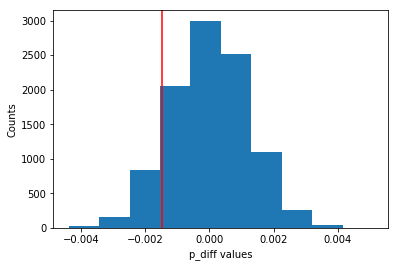

In [27]:
# Create a chart to visualize the distribution of the p_diffs
plt.hist(p_diffs)
plt.xlabel('p_diff values')
plt.ylabel('Counts')
plt.axvline(obs_diff, color = 'red')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [28]:
# Show the difference between the mean of p_diffs and the obs_diff observed in the df2 dataset
print(np.mean(p_diffs))
print(obs_diff)
p_value = (p_diffs > obs_diff).mean()
p_value

1.09295219265e-05
-0.00147959979408


0.88800000000000001

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**Put your answer here.**

**[Le Ho Quang Vu]**

1. The computed value in the part j above is called "p_value". In statistics, the p-value is the probability of obtaining results at least as extreme as the observed results of a statistical hypothesis test, assuming that the null hypothesis is correct. The p-value serves as an alternative to rejection points to provide the smallest level of significance at which the null hypothesis would be rejected. A smaller p-value means that there is stronger evidence in favor of the alternative hypothesis.

2. Based on the result above, it could be seen that the p_value with 0.8873 is higher than the Type I error rate with 0.05. Accordingly, it could be concluded that we fail to reject the null hypothesis and such, the company is recommended to maintain the old page where the conversion rate of it is considered as better than the new page.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [29]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2[(df2['converted'] == 1) & (df2['landing_page'] == "old_page")].landing_page.count()
print('Number of conversions with the old_page: ',convert_old)

# number of conversions with the new_page
convert_new = df2[(df2['converted'] == 1) & (df2['landing_page'] == "new_page")].landing_page.count()
print('Number of conversions with the new_page: ', convert_new)

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page'] == 'old_page'].landing_page.count()
print('Number of individuals who were shown the old page: ', n_old)
# # number of individuals who received new_page
n_new = df2[df2['landing_page'] == 'new_page'].landing_page.count()
print('Numbe of individuals who were shown the new page: ', n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Number of conversions with the old_page:  17489
Number of conversions with the new_page:  17264
Number of individuals who were shown the old page:  145274
Numbe of individuals who were shown the new page:  145309


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [30]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative = 'larger')
print('z_score: ',z_score)
print('p_vale: ', p_value)


z_score:  -1.31024085793
p_vale:  0.904942816116


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

>**Put your answer here.**

**[Le Ho Quang Vu]**

- The p_value returned by the built-in method is relatively similar to the one computed earlier (i.e. the p_value 0.095 from the built-in method and the p_value 0.089 computed earlier)
- Due to this is the right-tail test, this method also provides the same result with what we have already identified above where it is shown that we fail to reject the null hypothesis as the z_score is greater than the p_value. 

Therefore, there are solid evidences to not proceed the switch from the old landing page to new landing page where the change in conversion rate is not significant.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Put your answer here.**

**[Le Ho Quang Vu]**

Because the predicted response variable is limited to a probability between 0 and 1 since the data is either a conversion (i.e. 1) and no conversion (i.e. 0), the logistic regression should be selected to perform in this case.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [31]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [32]:
#create a dummy column ab_page
df3 = df2.copy()
df3[['control','ab_page']] = pd.get_dummies(df3['group'])
df3 = df3.drop('control',axis = 1)
df3.head()

#create intercept column
df3['intercept'] = 1

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [33]:
#instantiate the regression model on the 'intercept' and 'ab_page' columns
page_fit = sm.Logit(df3['converted'], df3[['intercept','ab_page']])
res_page = page_fit.fit()

Optimization terminated successfully.
         Current function value: 0.366119
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
# Because the function summary() could not present the summary of regression result, the function summary2() would be used for this purpose
# AttributeError: module 'scipy.stats' has no attribute 'chisqprob'.
# reference: https://stackoverflow.com/questions/49814258/statsmodel-attributeerror-module-scipy-stats-has-no-attribute-chisqprob

res_page.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-11-03 16:51 AIC:              212780.0972
No. Observations:   290583           BIC:              212801.2565
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3102  0.1901  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**Put your answer here.**

**[Le Ho Quang Vu]**

- The p_value are two-side in the binary logistic regression. Meanwhile, the Part II hypothesis testing is currently using right_side hypotheses: 

**$H_0$**: **$p_{old}$** $\ge$ **$p_{new}$**

**$H_1$**: **$p_{old}$** < **$p_{new}$**


- Therefore, the p_value associated with ab_page is 0.19 and this is completely different with the p_value computed above under the null hypothesis testing with the value of 0.88.
- Accordingly, the p_value associated with ab_page is not 0 and larger than Type 1 error rate (i.e. 0.05) showing us that the landing page is not statistically singnificant in predicting the customer's conversion rate.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Put your answer here.**

**[Le Ho Quang Vu]**

From my personal experience, only taking one factor for the analysis may lead to one-sided and lacking objectivity seletions and could not help generate adequate information for decisions. It is interesting to see an event or a selection from another aspects, such as the region where the users are living or which part of the day that a user would read the page, which may give us a whole picture of the users. 

However, considering too much factors into the analysis would lead us to another issue in generating the meaningful insight which is called "Multicollinearity", it is when the x-variables is related to one anothers. And this Multicollinearity has two potential negative impacts as follows:

1. The expected relationships between your x-variables and the response may not hold when multicollinearity is present

2. Our hypothesis testing results may not be reliable because having correlated explanatory variables means that our coefficient estimates are less stable.


**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [35]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
# Join with the df2 dataframe
df2 = df2.join(countries.set_index('user_id'), on ='user_id', how = 'left')
df2.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US


In [37]:
# Create the necessary dummy variables
df4 = df2.copy()
dum_country = pd.get_dummies(df4['country'])
dum_page = pd.DataFrame()
dum_page[['ab_page','old_page']] = pd.get_dummies(df4['landing_page'])
df4 = df4.join(dum_country, how = 'left')
df4 = df4.join(dum_page, how = 'left')
df4.head()

,user_id,timestamp,group,landing_page,converted,country,CA,UK,US,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US,0,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US,0,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US,0,0,1,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [38]:
df4['new_CA'] = df4['ab_page'] * df4['CA']
df4['new_UK'] = df4['ab_page'] * df4['UK']
df4['new_US'] = df4['ab_page'] * df4['US']

In [39]:
# Fit your model, and summarize the results
df4['intercept'] = 1
df4_fit = sm.Logit(df4['converted'],df4[['intercept','CA','UK','ab_page','new_CA','new_UK']])
df4_res = df4_fit.fit()
df4_res.summary2()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-11-03 16:51 AIC:              212782.4080
No. Observations:   290583           BIC:              212845.8859
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290577           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page      -0.0206    0.0137    -1.5044  0.1325  -0.0473   0.0062
new_CA       -0.0469    0.0538    -0.8720  0.3832  -0.1523   0.0585
new_UK        0.0314    0.0266     1.1803  0.2379  -0.0207   0.0835
==================================================================

"""

>**Put your conclusion answer here.**

**[Le Ho Quang Vu]**

1. The factor of region is added into the model and they still show that they are not statistically significant in the prediction of the conversion rate. Accordingly, the p_value of four factors are all higher than Type I error rate (0.05), so that, we fail to reject the null hypothesis and the old landing page is recommended to keep, rather than launching the new one

2. Overall, there are no outstanding signs or evidences for the company to replace the old landing page by the new one where for all cases, we fail to reject the null hypothesis which show us that the old page is now performing better. Therefore, it is recommended to keep the old landing page and we would switch to the new one when there are more signs or evidences that support this decision.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0